<a href="https://colab.research.google.com/github/sheldonkemper/bank_of_england/blob/main/notebooks/modelling/rb_flan_t5_summarisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

"""
===================================================
Bank of England Employer Project (Quant Collective)
Author: Rita Bini, Analytics and Data Science
Linkedin: https://www.linkedin.com/in/rita-bini/
Date: 2025-03-08
Version: 1.0

Description:
    This notebook contains a pipeline for a Flan-T5 (large)
    model for text summarisation of financial text. The model is integrated
    into our LLM workflow, it connects with topic and sentiment modeling to power
    an interactive insights tool.
===================================================
"""

'\n===================================================\nBank of England Employer Project (Quant Collective)\nAuthor: Rita Bini, Analytics and Data Science\nLinkedin: https://www.linkedin.com/in/rita-bini/\nDate: 2025-03-08\nVersion: 1.0\n\nDescription:\n    This notebook contains a pipeline for a Flan-T5 (large)\n    model for text summarisation of financial text. The model is integrated\n    into our LLM workflow, it connects with topic and sentiment modeling to power\n    an interactive insights tool.\n===================================================\n'

# **Imports**

In [2]:
!pip install umap-learn hdbscan sentence-transformers > /dev/null 2>&1
!pip install transformers torch > /dev/null 2>&1
!pip install tensorboard > /dev/null 2>&1
!pip install tensorflow > /dev/null 2>&1

In [3]:
import time
import torch
from google.colab import drive
import os
import sys
import pandas as pd
import re
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer,Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq
from typing import List, Union, Optional
import logging
import tensorflow as tf
import numpy as np
import random

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
def reset_session():
    tf.keras.backend.clear_session()
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)

# **Data loading**

In [5]:
# Load data (questions and answers for JPM and UBS)

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [8]:
path1 = "/content/drive/MyDrive/BOE/bank_of_england/data/preprocessed_data/jp_morgan_qna.csv"

path2 = "/content/drive/MyDrive/BOE/bank_of_england/data/preprocessed_data/ubs_qa_df_preprocessed_ver2.csv"

JP_qna = pd.read_csv(path1)
UBS_qna = pd.read_csv(path2)

In [9]:
JP_qna = JP_qna[JP_qna["Quarter"] != "1Q23"]
UBS_qna = UBS_qna[UBS_qna["Quarter"] != "1Q23"]

# **Model pipeline**

In [10]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


class TextSummarizer:
    def __init__(self, model_name: str = "google/flan-t5-large", device: Optional[str] = None):
        """Initialize the summarizer with model and device."""
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        logger.info(f"Using device: {self.device}")

        try:
            self.tokenizer = AutoTokenizer.from_pretrained(model_name)
            self.model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(self.device)
            logger.info(f"Successfully loaded {model_name}")
        except Exception as e:
            logger.error(f"Error loading model: {str(e)}")
            raise

    def chunk_text(self,
                  text: Union[str, List[str]],
                  chunk_size: int = 400,
                  overlap: int = 50) -> List[str]:
        """Split text into overlapping chunks."""

        if chunk_size <= 0 or overlap < 0 or overlap >= chunk_size:
            raise ValueError("Invalid chunk_size or overlap parameters")

        try:

            if isinstance(text, list):
                text = " ".join(text)

            if not text.strip():
                return []

            words = text.split()
            chunks = []
            start = 0

            while start < len(words):
                end = min(start + chunk_size, len(words))
                chunk = " ".join(words[start:end])
                chunks.append(chunk)
                start += chunk_size - overlap

            logger.debug(f"Split text into {len(chunks)} chunks")
            return chunks

        except Exception as e:
            logger.error(f"Error in chunk_text: {str(e)}")
            raise

    def summarize_text(self,
                      text: str,
                      min_new_tokens: int = 100,
                      max_new_tokens: int = 400) -> str:
        """Summarize a single piece of text."""

        if pd.isna(text) or not text.strip():
            logger.warning("Empty or NaN text provided")
            return ""

        try:
            prompt = f"Rewrite the following text into a concise and original summary while maintaining its key ideas: {text}"


            inputs = self.tokenizer(
                prompt,
                return_tensors="pt",
                truncation=True,
                max_length=512
            ).to(self.device)


            with torch.no_grad():
                outputs = self.model.generate(
                    inputs.input_ids,
                    min_new_tokens=min_new_tokens,
                    max_new_tokens=max_new_tokens,
                    num_beams=4,
                    length_penalty=2,
                    no_repeat_ngram_size=3,
                    early_stopping=True,
                    do_sample=False
                )

            summary = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
            return summary

        except Exception as e:
            logger.error(f"Error in summarize_text: {str(e)}")
            raise

    def summarize_long_text(self,
                          text: Union[str, List[str]],
                          chunk_size: int = 300,
                          overlap: int = 50) -> str:
        """Handle long text summarization."""
        try:
            # Get chunks
            chunks = self.chunk_text(text, chunk_size, overlap)
            if not chunks:
                logger.warning("No valid chunks to summarize")
                return ""

            # Summarize chunks
            chunk_summaries = []
            for i, chunk in enumerate(chunks):
                logger.debug(f"Summarizing chunk {i+1}/{len(chunks)}")
                summary = self.summarize_text(chunk)
                if summary.strip():
                    chunk_summaries.append(summary)

            if not chunk_summaries:
                logger.warning("No valid summaries generated")
                return ""


            if len(chunk_summaries) == 1:
                return chunk_summaries[0]

            # Summarize the combined summaries
            logger.debug("Generating final summary")
            final_summary = self.summarize_text(
                " ".join(chunk_summaries),
                min_new_tokens=150,
                max_new_tokens=300
            )

            return final_summary

        except Exception as e:
            logger.error(f"Error in summarize_long_text: {str(e)}")
            raise


# **Applying model to all quarters and to analysts level data**

###**JPMorgan**

In [ ]:
summarizer = TextSummarizer()

summary_data = []

quarter_years = JP_qna["Quarter"].unique()
analysts = JP_qna["Analyst"].unique()

# Loop through each unique Quarter-Year and Analyst
for quarter in quarter_years:
    for analyst in analysts:
        filtered_df = JP_qna[(JP_qna["Quarter"] == quarter) & (JP_qna["Analyst"] == analyst)]

        snippets = filtered_df["Response"].dropna().astype(str).tolist()

        if not snippets:
            logger.warning(f"No valid snippets found for Quarter-Year: {quarter}, Analyst: {analyst}")
            continue

        print(type(summarizer))
        # Generate the summary for the text in this Quarter-Year and Analyst
        try:
            summary_text = summarizer.summarize_long_text(snippets)
        except Exception as e:
            logger.error(f"Error summarizing for Quarter {quarter}, Analyst {analyst}: {str(e)}")
            continue

        summary_data.append({"Summary": summary_text, "Quarter": quarter, "Analyst": analyst})

df_summaryJPM = pd.DataFrame(summary_data)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

<class '__main__.TextSummarizer'>


###**UBS**

In [ ]:
reset_session()

In [ ]:
summarizer = TextSummarizer()

summary_dataUBS = []

quarter_years = UBS_qna["Quarter"].unique()
analysts = UBS_qna["Analyst_Bank"].unique()

# Loop through each unique Quarter-Year and Analyst
for quarter in quarter_years:
    for analyst in analysts:
        filtered_df = UBS_qna[(UBS_qna["Quarter"] == quarter) & (UBS_qna["Analyst_Bank"] == analyst)]

        snippets = filtered_df["Response"].dropna().astype(str).tolist()

        if not snippets:
            logger.warning(f"No valid snippets found for Quarter-Year: {quarter}, Analyst_Bank: {analyst}")
            continue

        print(type(summarizer))
        # Generate the summary for the text in this Quarter-Year and Analyst
        try:
            summary_text = summarizer.summarize_long_text(snippets)
        except Exception as e:
            logger.error(f"Error summarizing for Quarter {quarter}, Analyst_Bank {analyst}: {str(e)}")
            continue

        summary_dataUBS.append({"Summary": summary_text, "Quarter": quarter, "Analyst_Bank": analyst})

df_summaryUBS = pd.DataFrame(summary_dataUBS)

# **Export Output Datasets**

In [ ]:
#Save CSVs
file_path_1 = "/content/drive/MyDrive/bank_of_england/data/model_outputs/sent_output/summary_output_JPM.csv"
file_path_2 = "/content/drive/MyDrive/bank_of_england/data/model_outputs/sent_output/summary_output_UBS.csv"

df_summaryJPM.to_csv(file_path_1, index=False)
df_summaryUBS.to_csv(file_path_2, index=False)

.

# **LLM Pipeline**

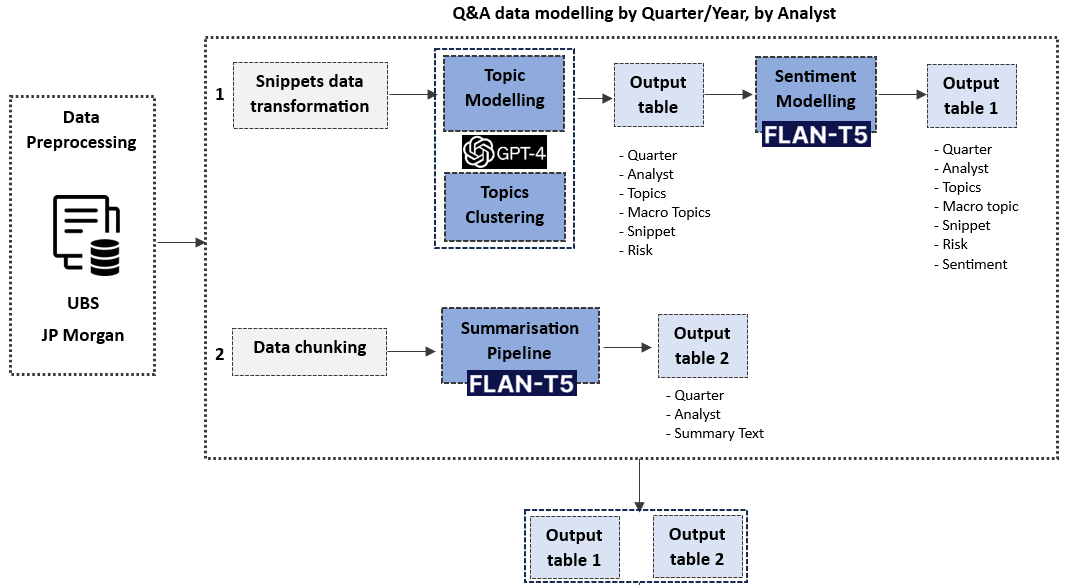

# **Interactive tool to extract key topics and text summary from analysts and leadership conversations**

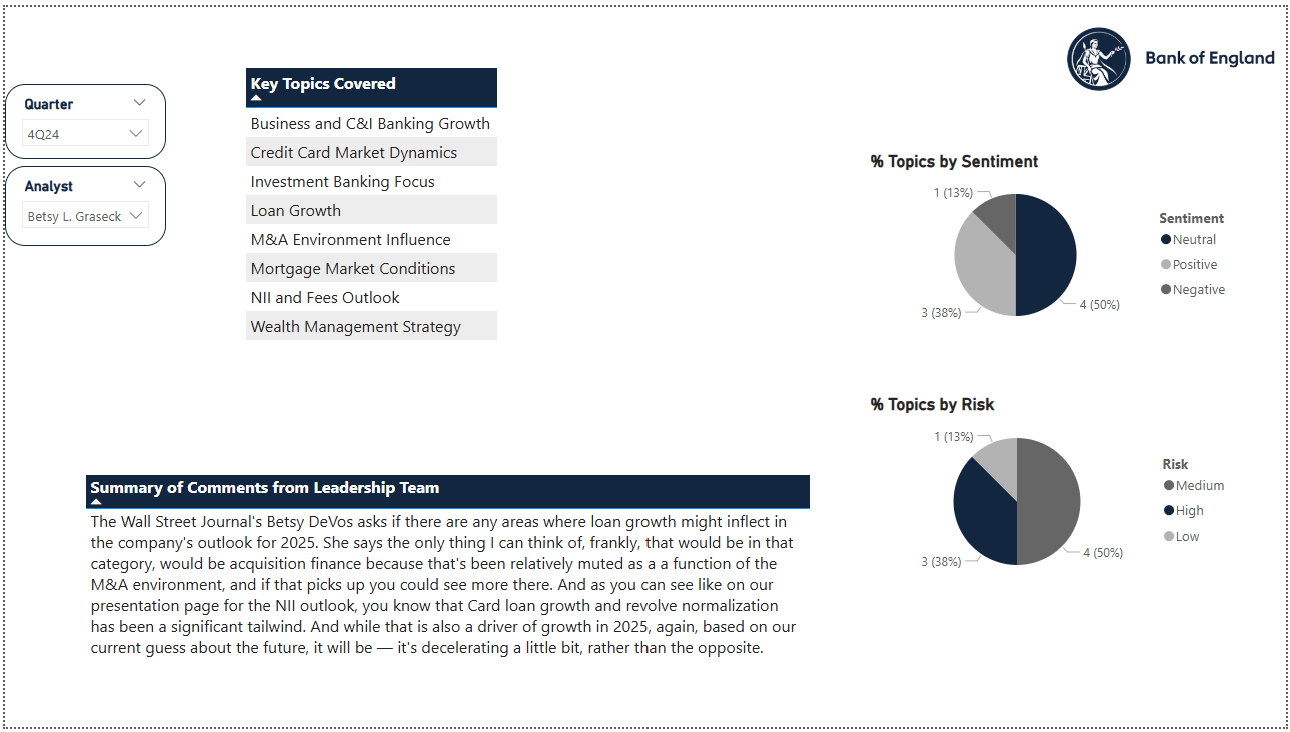